In [1]:
import librosa
import psola
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
from pathlib import Path
from audioUtilityFunctions import trim, apply_hann_window_fades
import scipy
import os


### CONSTANTS

In [2]:
TRIM_DURATION_SECONDS = 0.5 # duration to trim each sample to before processing
FADE_DURATION_SECONDS = 0.03  # 30ms fade to be added before processing, after trim.
SAMPLE_RATE = 22050 # samples will be resampled to this on load
N_FFT_MS = 200
HOP_LENGTH_MS = 1
FILE1 = 'samples/singlenotes/york/sm57/york_013_C2_sm57.wav'
# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4
pitch = librosa.note_to_hz('C2')


In [14]:
y, sr = librosa.load(FILE1,sr=SAMPLE_RATE)
print(f"File 1: {FILE1}")
display(Audio(data=y, rate=sr))

File 1: samples/singlenotes/york/sm57/york_013_C2_sm57.wav


### PITCH ESTIMATION PLOTTING

In [15]:
def plot_pitch_estimation(y, sr, f0, f0_estimation_hop_length, viz_frame_length, viz_hop_length, freq_focus, freq_range=0.5):
    if viz_hop_length is None:
        viz_hop_length = viz_frame_length // 4
    
    
    y_min = freq_focus * (1 - freq_range)
    y_max = freq_focus * (1 + freq_range)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(y, n_fft=viz_frame_length, hop_length=viz_hop_length)), 
        ref=np.max
    )
    img = librosa.display.specshow(
        D, y_axis='hz', x_axis='time', 
        ax=ax, vmin=-80, vmax=0,
        hop_length=viz_hop_length,
        sr=sr,
        cmap='viridis'
    )
    
    times = librosa.times_like(f0, sr=sr, hop_length=f0_estimation_hop_length)
    ax.plot(times, f0, color='r', linewidth=1, alpha=1.0, label='f0')
    
    ymin, ymax = 0, 200
    ax.set_ylim(y_min, y_max)
    tick_spacing = freq_focus * 0.05
    yticks = np.arange(y_min, y_max, tick_spacing)
    ax.set_yticks(yticks)
    ax.grid(True, alpha=0.3)
    
    fig.colorbar(img, format='%+2.0f dB', pad=0.01)
    plt.tight_layout()
    return fig, ax


### Get Pitch Estimation


[        nan         nan         nan         nan         nan         nan
         nan 65.12411125 65.12411125 65.50137139 65.88081698 66.26246067
 66.26246067 66.26246067 65.88081698 65.88081698 65.88081698 66.26246067
 65.88081698 65.88081698 65.88081698 65.88081698 65.88081698 65.88081698
 65.88081698 65.88081698 65.88081698 65.88081698 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067 66.26246067
 66.26246067 66.26246067 66.26246067 66.26246067 65

Text(0.5, 1.0, 'samples/singlenotes/york/sm57/york_013_C2_sm57.wav')

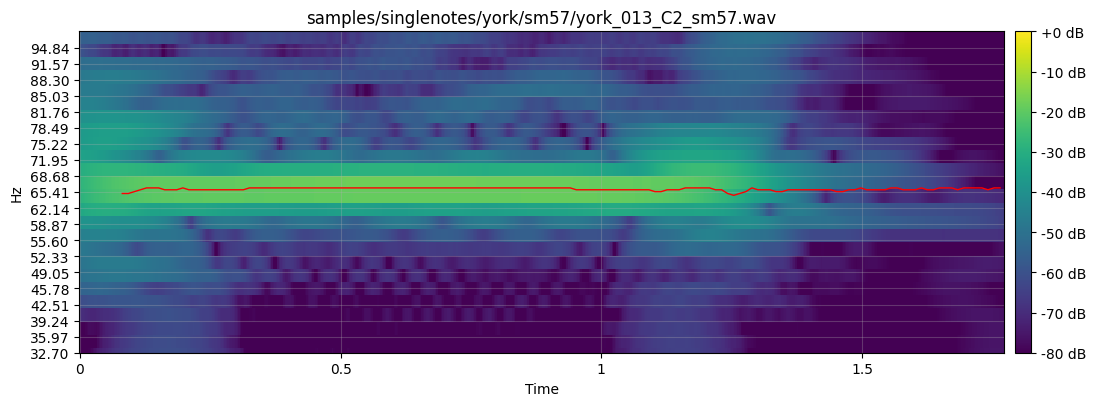

In [16]:
# F0 params
pitchRange = pitch

# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4

# Extract F0 with explicit parameters
f0, unused, unused, = librosa.pyin(
    y, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=pitchRange*0.7,
    fmax=pitchRange*1.3 
)

print(f0)

# Visualization of y
plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=pitch
)
plt.title(f"{FILE1}")

### Autotune with PSOLA

original audio:


auto-tuned audio:


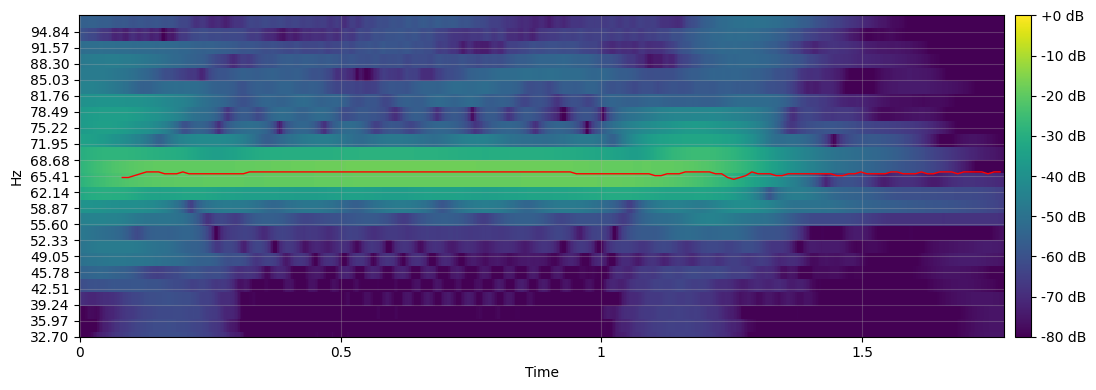

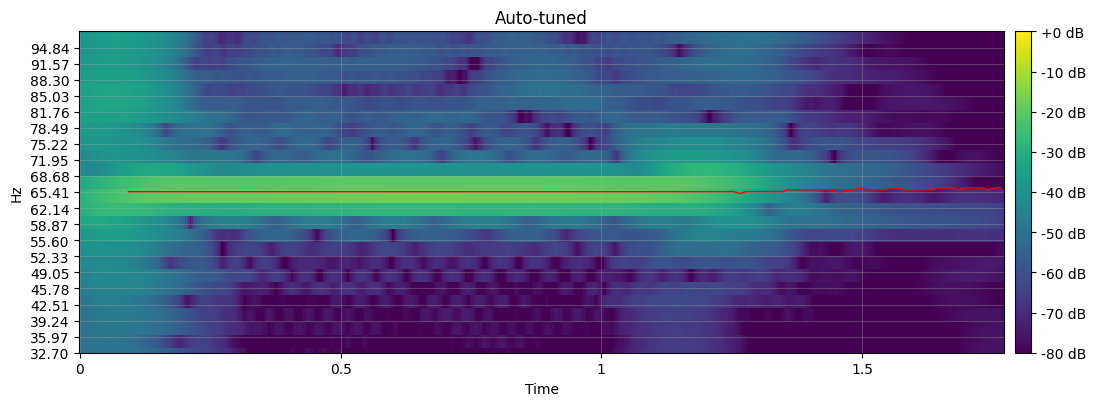

In [17]:
target_pitch = pitch
target_pitch_array = np.full_like(f0, target_pitch)
tuned = psola.vocode(y, sr, target_pitch=target_pitch_array, fmin=20, fmax=600)

# Extract F0 with explicit parameters
tuned_f0, unused, unused = librosa.pyin(
    tuned, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=target_pitch*0.7,
    fmax=target_pitch*1.3 )

plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=target_pitch
)

# Visualization
plot_pitch_estimation(
    tuned, sr, tuned_f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=target_pitch
)

plt.title('Auto-tuned')

print("original audio:")
display(Audio(y, rate=sr))
print("auto-tuned audio:")
display(Audio(tuned, rate=sr))

### BATCH


In [9]:
pitches = np.arange(librosa.note_to_midi('C1'), librosa.note_to_midi('G#4'), dtype=float)
for index, pitch in enumerate(pitches):
    pitches[index] = librosa.midi_to_hz(pitch)
pitches

array([ 32.70319566,  34.64782887,  36.70809599,  38.89087297,
        41.20344461,  43.65352893,  46.24930284,  48.9994295 ,
        51.9130872 ,  55.        ,  58.27047019,  61.73541266,
        65.40639133,  69.29565774,  73.41619198,  77.78174593,
        82.40688923,  87.30705786,  92.49860568,  97.998859  ,
       103.82617439, 110.        , 116.54094038, 123.47082531,
       130.81278265, 138.59131549, 146.83238396, 155.56349186,
       164.81377846, 174.61411572, 184.99721136, 195.99771799,
       207.65234879, 220.        , 233.08188076, 246.94165063,
       261.6255653 , 277.18263098, 293.66476792, 311.12698372,
       329.62755691, 349.22823143, 369.99442271, 391.99543598])

In [15]:
# Get all wav files in the input folder
wav_files = sorted(Path('500msTrimmedSamples/yamaha').glob('*.wav'))

# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4
    
    
# get file and index of file 
for index, file in enumerate(wav_files[:44]):
    # Load audio file
    y, sr = librosa.load(str(file), sr=SAMPLE_RATE)
    title = os.path.basename(file)
    
    # F0 params
    pitch = pitches[index]
    

    # Extract F0 with explicit parameters
    f0, unused, unused, = librosa.pyin(
        y, 
        sr=SAMPLE_RATE,
        frame_length=f0_estimation_frame_length,
        win_length=f0_estimation_window_length,
        hop_length=f0_estimation_hop_length,
        fmin=pitch*0.7,
        fmax=pitch*1.3 
    )
    
    target_pitch = pitch
    target_pitch_array = np.full_like(f0, target_pitch)
    tuned = psola.vocode(y, sr, target_pitch=target_pitch_array, fmin=target_pitch*0.7, fmax=target_pitch*1.3)

    tuned = librosa.util.normalize(tuned)
    # write tuned to a file
    scipy.io.wavfile.write(f"combinedTuningMethod500msNormalizedSamples/yamaha/Praat500msTunedNorm_{title}", sr, tuned)
    
    

In [ ]:

# Load audio files
y, sr = librosa.load('samples/singlenotes/york/sm57/york_013_C2_sm57.wav', sr=SAMPLE_RATE)
tuned, sr = librosa.load('tuned_samples/tuned_york_013_C2_sm57.wav', sr=SAMPLE_RATE)

pitchRange = pitches[12]
print(pitchRange)

target_pitch = pitchRange

# Extract Original F0
f0, unused, unused = librosa.pyin(
    y, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=pitchRange*0.7,
    fmax=pitchRange*1.3 
)

print(f'f0 of original: {f0}')
plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=pitchRange
)


# Extract Tuned F0 
tuned_f0, unused, unused = librosa.pyin(
    tuned, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=target_pitch*0.7,
    fmax=target_pitch*1.3 )
print(f'f0 of tuned: {tuned_f0}')

# Visualization
plot_pitch_estimation(
    tuned, sr, tuned_f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=target_pitch
)

plt.title('Auto-tuned')


# # Add spacing between plots
# plt.tight_layout()
# plt.show()

In [ ]:

originalFiles = sorted(Path('samples/singlenotes/yamaha/sm57').glob('*.wav'))
tunedFiles = sorted(Path('tuned_samples/yamaha').glob('*.wav'))

for i in range(45):
    print(f'Processing file {i+1}/45')

    # Load audio files
    y, sr = librosa.load(originalFiles[i], sr=SAMPLE_RATE)
    tuned, sr = librosa.load(tunedFiles[i], sr=SAMPLE_RATE)


    pitchRange = pitches[i]
    target_pitch = pitchRange
    
    
    # Extract Original F0
    f0, unused, unused = librosa.pyin(
        y, 
        sr=SAMPLE_RATE,
        frame_length=f0_estimation_frame_length,
        win_length=f0_estimation_window_length,
        hop_length=f0_estimation_hop_length,
        fmin=pitchRange*0.7,
        fmax=pitchRange*1.3 
    )

    # Plot Original
    plot_pitch_estimation(
        y, sr, f0, 
        f0_estimation_hop_length=f0_estimation_hop_length,
        viz_frame_length=8192,
        viz_hop_length=64,
        freq_focus=target_pitch
    )
    plt.title(f'Original - File {i+1}')

    # Extract Tuned F0
    tuned_f0, unused, unused = librosa.pyin(
        tuned, 
        sr=SAMPLE_RATE,
        frame_length=f0_estimation_frame_length,
        win_length=f0_estimation_window_length,
        hop_length=f0_estimation_hop_length,
        fmin=target_pitch*0.7,
        fmax=target_pitch*1.3 
    )

    # Plot Tuned
    plot_pitch_estimation(
        tuned, sr, tuned_f0, 
        f0_estimation_hop_length=f0_estimation_hop_length,
        viz_frame_length=8192,
        viz_hop_length=64,
        freq_focus=target_pitch
    )
    plt.title(f'Auto-tuned - File {i+1}')

    # Play audio (if in Jupyter notebook)
    print(f"\nFile {i+1} original audio:")
    display(Audio(y, rate=sr))
    print(f"File {i+1} auto-tuned audio:")
    display(Audio(tuned, rate=sr))

    # Add spacing between plots
    plt.tight_layout()
    plt.show()






In [1]:
y, sr = librosa.load('samples/singlenotes/york/sm57/york_013_C2_sm57.wav', sr=SAMPLE_RATE)

# F0 params
pitchRange = librosa.note_to_hz('C2')

# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4

# Extract F0 with explicit parameters
f0, unused, unused, = librosa.pyin(
    y, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=pitchRange*0.7,
    fmax=pitchRange*1.3 
)

print(f0)

# Visualization of y
plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=pitch
)
plt.title(f"untuned")


####################


y, sr = librosa.load('praatTuned_york_013_C2_sm57.wav', sr=SAMPLE_RATE)

# F0 params
pitchRange = librosa.note_to_hz('C2')

# estimation params
f0_estimation_frame_length = 2048
f0_estimation_window_length = f0_estimation_frame_length // 2
f0_estimation_hop_length = f0_estimation_window_length // 4

# Extract F0 with explicit parameters
f0, unused, unused, = librosa.pyin(
    y, 
    sr=SAMPLE_RATE,
    frame_length=f0_estimation_frame_length,
    win_length=f0_estimation_window_length,
    hop_length=f0_estimation_hop_length,
    fmin=pitchRange*0.7,
    fmax=pitchRange*1.3 
)

print(f0)

# Visualization of y
plot_pitch_estimation(
    y, sr, f0, 
    f0_estimation_hop_length=f0_estimation_hop_length,
    viz_frame_length=8192,
    viz_hop_length=64,
    freq_focus=pitch
)
plt.title(f"tuned")

NameError: name 'librosa' is not defined